# Dataloader Tutorial
* To start a new notebook for model training, open a new Kaggle Notebook.
* Add the created private dataset by clicking "+ Add Input" on the righ-side pane. You should see the fracture_dataset_subset.h5 file there.

This notebook demonstrates how to go about loading the data from the private Kaggle dataset you had created in notebook 00. Here, we show you how to import the GitHub repository dataloader script into your notebook on Kaggle, how to view data samples from the preprocessed h5 file, and how to get the dataloaders based on the task at hand: 'classification' or 'detection'.

In [1]:
# Import libraries
import h5py
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import random

In [2]:
# Import GitHub repo
# Repo files will appear in the /kaggle/working folder
!git clone https://github.com/apmalinsky/AAI-590-Capstone.git

scripts_path = '/kaggle/working/AAI-590-Capstone/scripts'

# Add the scripts folder to system path for importing
if scripts_path not in sys.path:
    sys.path.append(scripts_path)
    print(f'Added {scripts_path} to Python path.')
else:
    print(f'{scripts_path} is already in the path.')

# Import data loader helper script
from dataloader import get_dataloaders
print('Dataloader script loaded!')

Cloning into 'AAI-590-Capstone'...
remote: Enumerating objects: 64, done.
remote: Counting objects: 100% (54/54), done.
remote: Compressing objects: 100% (45/45), done.
remote: Total 64 (delta 18), reused 26 (delta 6), pack-reused 10 (from 3)
Receiving objects: 100% (64/64), 2.34 MiB | 19.00 MiB/s, done.
Resolving deltas: 100% (18/18), done.
Added /kaggle/working/AAI-590-Capstone/scripts to Python path.
Dataloader script loaded!


In [3]:
# View data file
data_path = '/kaggle/input/rsna-2022-hdf5-subset/fracture_dataset_subset.h5'

# Open the file
with h5py.File(data_path, 'r') as f:
    # View key list, essentially our 'columns'
    print(f'Keys: {list(f.keys())}')

    # View column shapes
    print('\n--- Details ---')
    for key in f.keys():
        dataset = f[key]
        print(f'\nKey: {key}')
        print(f'Shape: {dataset.shape}')
        print(f'Dtype: {dataset.dtype}')

Keys: ['SliceNumber', 'StudyInstanceUID', 'bboxes', 'images', 'labels', 'split']

--- Details ---

Key: SliceNumber
Shape: (28868,)
Dtype: object

Key: StudyInstanceUID
Shape: (28868,)
Dtype: object

Key: bboxes
Shape: (28868, 10, 4)
Dtype: float32

Key: images
Shape: (28868, 256, 256)
Dtype: float32

Key: labels
Shape: (28868,)
Dtype: int8

Key: split
Shape: (28868,)
Dtype: int8


In [4]:
# View the first sample data
with h5py.File(data_path, 'r') as f:
    slice_number = f['SliceNumber'][0]
    study_instance_uid = f['StudyInstanceUID'][0]
    bbox = f['bboxes'][0]
    image = f['images'][0]
    label = f['labels'][0]
    split = f['split'][0]

print(f'SliceNumber: {slice_number}')
print(f'StudyInstanceUID: {study_instance_uid}')
print(f'Boxes: {bbox} (-1 is padding, which means no box)')
print(f'Image shape: {image.shape}')
print(f'Label: {label} (0=no fracture, 1=fracture)')
print(f'Split: {split} (0=train, 1=validation, 2=test)')

SliceNumber: b'59'
StudyInstanceUID: b'1.2.826.0.1.3680043.14345'
Boxes: [[-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]
 [-1. -1. -1. -1.]] (-1 is padding, which means no box)
Image shape: (256, 256)
Label: 0 (0=no fracture, 1=fracture)
Split: 0 (0=train, 1=validation, 2=test)


In [5]:
# Define visualizer function
def visualize_samples(num_samples, label):
    with h5py.File(data_path, 'r') as hf:
        # Load all labels and find the indices for the desired sample type
        all_labels = hf['labels'][:]
        indices_to_sample_from = np.where(all_labels == label)[0]
        sample_indices = random.sample(list(indices_to_sample_from), num_samples)
        fig, axes = plt.subplots(1, num_samples, figsize=(10, 10))
    
        for ax, idx in zip(axes, sample_indices):
            # Load the data for this one sample
            image = hf['images'][idx]
            bboxes = hf['bboxes'][idx]
            uid = hf['StudyInstanceUID'][idx]
            slice_num = hf['SliceNumber'][idx]
            label = hf['labels'][idx]
            
            # Filter out the "-1" padding on the bounding boxes
            bboxes = [box for box in bboxes if box[0] != -1.0]
            
            # Plot the image
            ax.imshow(image, cmap='bone')
            # Set title
            ax.set_title(f'Negative Sample (Label: {label}) \nSlice: {slice_num} | (Index: {idx})')
            
            # Plot each bounding box
            for box in bboxes:
                x, y, w, h = box # the box value contains its coordinates and dimensions
    
                # Draw the bounding box on the image
                rect = patches.Rectangle(
                    (x, y), w, h,
                    linewidth=2,
                    edgecolor='r',
                    facecolor='none'
                )
                ax.add_patch(rect)
                
        plt.tight_layout()
        plt.show()

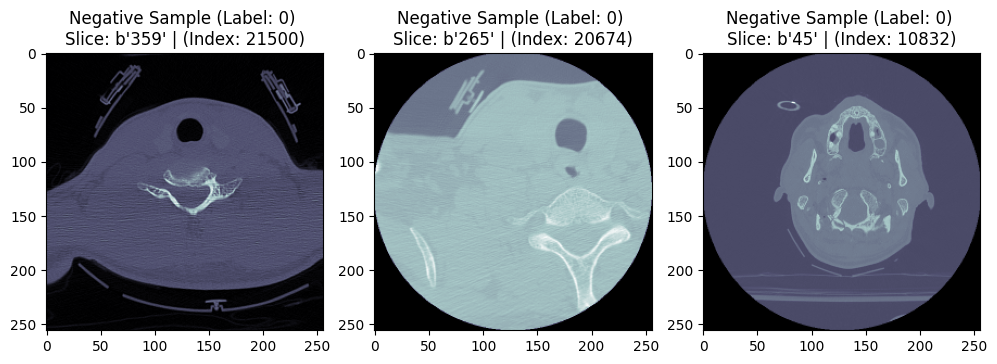

In [6]:
# View 3 sample negative images
visualize_samples(3, 0)

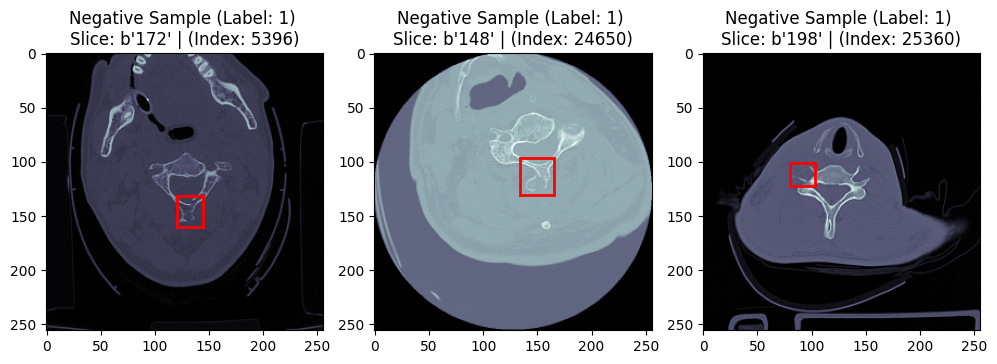

In [7]:
# View 3 sample positive images
visualize_samples(3, 1)

## Classification Dataloaders
* Returns: (images, labels)
* Images: A single tensor: [BatchSize, 1, 256, 256]
* Labels: A single tensor: [BatchSize] (with values 0 or 1)

In [10]:
# Get data loaders for classification
batch_size = 32

train_loader_cls, val_loader_cls, test_loader_cls = get_dataloaders(
    hdf5_path=data_path, 
    batch_size=batch_size,
    task='classification'
)

Loading dataset for task: 'classification'...
Loading pre-defined train/val/test splits...
Total samples: 28868
  Training indices:   20207
  Validation indices: 4330
  Test indices:       4331
DataLoaders created successfully.


## Detection Dataloaders
* Returns: (images, targets)
* Images: A list of image tensors (length BatchSize)
* Targets: A list of target dictionaries (length BatchSize)

In [12]:
# Get data loaders for detection
batch_size = 8 # lower batch size since detection models need more memory

train_loader_det, val_loader_det, test_loader_det = get_dataloaders(
    hdf5_path=data_path, 
    batch_size=batch_size,
    task='detection'
)

Loading dataset for task: 'detection'...
Loading pre-defined train/val/test splits...
Total samples: 28868
  Training indices:   20207
  Validation indices: 4330
  Test indices:       4331
DataLoaders created successfully.


## Use the Dataloaders for Model Training and Evaluation
1. Get the dataloaders for your task (classification vs detection)
2. Define your model
3. Perform training loop
   * Load images in batches "for images, labels in tqdm(train_loader_cls, desc='Training Batch'):"